In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import tarfile
import os

data_base_path = os.path.join('data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [2]:
import numpy as np
import sklearn
import scipy
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.covariance import LedoitWolf
import seaborn as sns

In [3]:
import torch 

# Label mapping
label_to_classname = {0 : "TUMOR", 1 : "STROMA"}

# Train features and labels
train_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_features.pth"))
train_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_train_labels.pth"))

# Test features and labels
test_features = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_features.pth"))
test_labels = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test_labels.pth"))

test_features.shape

torch.Size([186, 768])

In [4]:
print(train_features.shape)
train_labels.reshape(-1,1).shape

torch.Size([878, 768])


(878, 1)

In [5]:
train_data = np.hstack((train_features,train_labels.reshape(-1,1)))
test_data = np.hstack((train_features,train_labels.reshape(-1,1)))
test_features[test_labels==1].numpy().shape

(93, 768)

In [6]:
#np.cov(test_features[])
x = np.array([[0,1,0],[0,1,0]])
cov = LedoitWolf().fit(x)
#cov.covariance_
mu = np.mean(x,axis=0)
np.dot(mu,cov.covariance_)

array([0., 0., 0.])

### 1.1

In [8]:
from numpy import linalg

def mahalanobis_dist(x,inv,mu):
    output = np.dot(inv,x-mu)
    output = np.dot(x-mu, output)
    return np.sqrt(output)

class mahalanobis_classifier():
    def __init__(self):
        self.covariances = []
        self.inverses = []
        self.means = []
        self.n_classes = 2
        self.labels = None
        
    def fit(self,X_train,y_train):
        self.n_classes = len(np.unique(y_train))
        self.labels = np.unique(y_train)
        for i in range(self.n_classes):
            data = X_train[y_train==self.labels[i]]
            #print(data)
            cov = LedoitWolf().fit(data).covariance_
            mu = np.mean(data,axis=0)
            inv = linalg.inv(cov)
            self.covariances.append(cov)
            self.means.append(mu)
            self.inverses.append(inv)
        
    def predict(self, X_test):
        output = []
        for x in X_test:
            distances = [mahalanobis_dist(x,self.inverses[i],self.means[i]) for i in range(self.n_classes)]
            output.append(self.labels[np.argmin(distances)])
        return np.array(output)
    
    def get_min_distances(self, X_test):
        output = []
        for x in X_test:
            distances = [mahalanobis_dist(x,self.inverses[i],self.means[i]) for i in range(self.n_classes)]
            output.append(min(distances))
        return np.array(output)
    
    def get_distances(self, X_test):
        output = []
        for x in X_test:
            distances = [mahalanobis_dist(x,self.inverses[i],self.means[i]) for i in range(self.n_classes)]
            output.append(min(distances))
        return np.array(output)

In [9]:
X_train = train_features.numpy()
y_train = train_labels
X_test = test_features.numpy()
y_test = test_labels

clf = mahalanobis_classifier()
clf.fit(X_train,y_train)
y_hat = clf.predict(X_test)

print(np.mean(y_hat==y_test))

0.978494623655914


### 1.2

In [10]:
label_to_classname_w_ood = {0 : "TUMOR", 1 : "STROMA", -1 : "OoD"}

# Test features and labels with OoD tissues
test_features_w_ood = torch.load(os.path.join(data_base_path, data_folder, "part1/k16_test2_features.pth"))
test_labels_w_ood = torch.load(os.path.join(data_base_path, data_folder,"part1/k16_test2_labels.pth"))

test_features_w_ood.shape

torch.Size([744, 768])

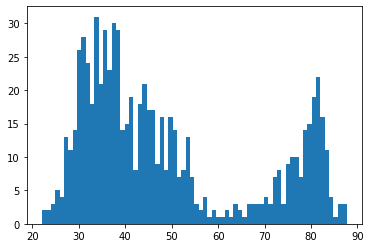

In [11]:
X_test_new = test_features_w_ood.numpy()
y_test_new = test_labels_w_ood

distances = clf.get_min_distances(X_test_new)
plt.hist(distances,bins=70)
plt.show()

In [12]:
train_distances = clf.get_min_distances(X_train)
#thresh = np.max(train_distances)

thresh = 31
#X_test_id = X_test[distances<thresh]
#y_hat_new = np.append(clf.predict(X_test_id),)
y_hat_new = np.zeros_like(y_test_new)
for i in range(len(X_test_new)):
    if distances[i]>thresh:
        y_hat_new[i] = -1
    else:
        y_hat_new[i] = clf.predict([X_test_new[i]])[0]
        
print("portion of ",np.sum(y_test_new==-1)/len(y_test_new))
print('new_accuracy',np.mean(y_hat_new==y_test_new))

portion of  0.75
new_accuracy 0.793010752688172


In [13]:
train_distances = clf.min_distances(X_train)
plt.hist(train_distances,bins=20)
plt.show()
thresh = np.max(train_distances)
print(thresh)

AttributeError: 'mahalanobis_classifier' object has no attribute 'min_distances'

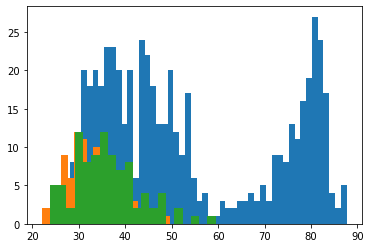

In [14]:
#Task 3

index_0 = (y_test_new==0)
distances_0 = distances[y_test_new==0]
distances_1 = distances[y_test_new==1]
distances_ood = distances[y_test_new==-1]
plt.hist(distances_ood,bins=50)
plt.hist(distances_0,bins=20)
plt.hist(distances_1,bins=20)
plt.show()

In [15]:
#Task 4

thresh_ood_5 = np.sort(distances_ood)[int(len(distances_ood)*0.05)]
print("0.05 quantile of OOD samples:",thresh_ood_5)

#Task 5

y_hat_new = np.zeros_like(y_test_new)
for i in range(len(X_test_new)):
    if distances[i]>thresh_ood_5:
        y_hat_new[i] = -1
    else:
        y_hat_new[i] = clf.predict([X_test_new[i]])[0]
        
print('new_accuracy',np.mean(y_hat_new==y_test_new))
print('class 0 filtered out:',sum(distances_0>thresh_ood_5)/len(distances_0))
print('class 1 filtered out:',sum(distances_1>thresh_ood_5)/len(distances_1))

0.05 quantile of OOD samples: 30.65177
new_accuracy 0.7903225806451613
class 0 filtered out: 0.6129032258064516
class 1 filtered out: 0.7634408602150538


### 1.3

In [16]:
#Task 1

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

class KNNClassifier(KNeighborsClassifier):
    def ood_metric(self,X,k_neighbors=None,p=2):
        if k_neighbors==None:
            k_neighbors=self.n_neighbors            
        neigh_distances = self.kneighbors(X,k_neighbors,return_distance=True)[0]
        neigh_distances = np.array(neigh_distances)
        output = []
        for d in neigh_distances:
            if p==0:
                out = np.max(d)
            elif p=='infty':
                out = np.min(d)
            else:
                out = np.sum(d**p)**(1/p)
            output.append(out)
        return np.array(output)
    def predict_ood(self,X,metrics,threshold,ood_label=-1):
        output = self.predict(X)
        for i in range(len(X)):
            if metrics[i]>threshold:
                output=ood_label
        return output
            
knn = KNNClassifier(n_neighbors=5,weights='distance') # brute knn
knn.fit(X_train,y_train)
y_hat_brute = knn.predict(X_test)
print(np.mean(y_hat_brute==y_test))

0.9946236559139785


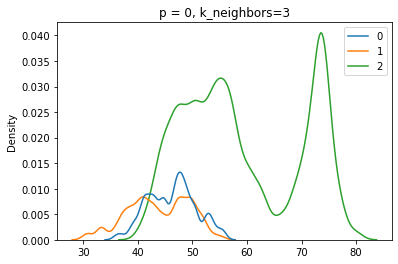

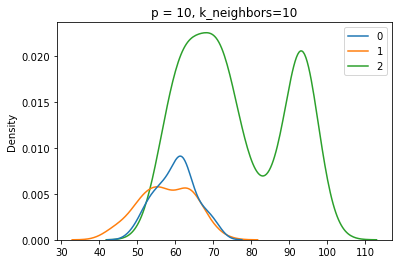

In [17]:
p = 0
k_neighbors = 3
metrics_0 = knn.ood_metric(X_test_new[y_test_new==0],k_neighbors=k_neighbors,p=p)
metrics_1 = knn.ood_metric(X_test_new[y_test_new==1],k_neighbors=k_neighbors,p=p)
metrics_ood = knn.ood_metric(X_test_new[y_test_new==-1],k_neighbors=k_neighbors,p=p)
plt.figure()
sns.kdeplot(data=[metrics_0,metrics_1,metrics_ood],bw_adjust=0.4)
plt.title(f"p = {p}, k_neighbors={k_neighbors}")
plt.show()

p = 10
k_neighbors = 10
metrics_0 = knn.ood_metric(X_test_new[y_test_new==0],k_neighbors=k_neighbors,p=p)
metrics_1 = knn.ood_metric(X_test_new[y_test_new==1],k_neighbors=k_neighbors,p=p)
metrics_ood = knn.ood_metric(X_test_new[y_test_new==-1],k_neighbors=k_neighbors,p=p)
plt.figure()
sns.kdeplot(data=[metrics_0,metrics_1,metrics_ood],bw_adjust=1)
plt.title(f"p = {p}, k_neighbors={k_neighbors}")
plt.show()

In [18]:
p = 0
k_neighbors = 3
metrics = knn.ood_metric(X_test_new,k_neighbors=k_neighbors,p=p)
y_hat_new_knn = knn.predict_ood(X_test_new,metrics,120)
print(np.mean(y_hat_new_knn==y_test_new))

0.24865591397849462


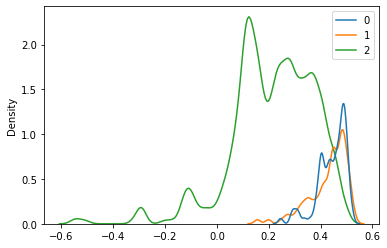

0.05 quantile of OOD samples: 30.65177
new_accuracy 0.8521505376344086
class 0 filtered out: 0.5591397849462365
class 1 filtered out: 0.5698924731182796


In [19]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=3,novelty=True)
lof.fit(X_train,y_train)

goodness_score = lof.decision_function(X_test_new)
goodness_0 = lof.decision_function(X_test_new[y_test_new==0])
goodness_1 = lof.decision_function(X_test_new[y_test_new==1])
goodness_ood = lof.decision_function(X_test_new[y_test_new==-1])

plt.figure()
sns.kdeplot(data=[goodness_0,goodness_1,goodness_ood],bw_adjust=0.4)
plt.show()

thresh_ood_95 = np.sort(goodness_ood)[int(len(goodness_ood)*0.95)]
print("0.05 quantile of OOD samples:",thresh_ood_5)

#Task 5

y_hat_new = np.zeros_like(y_test_new)
for i in range(len(X_test_new)):
    if goodness_score[i]<thresh_ood_95:
        y_hat_new[i] = -1
    else:
        y_hat_new[i] = clf.predict([X_test_new[i]])[0]
        
print('new_accuracy',np.mean(y_hat_new==y_test_new))
print('class 0 filtered out:',sum(goodness_0>thresh_ood_95)/len(goodness_0))
print('class 1 filtered out:',sum(goodness_1>thresh_ood_95)/len(goodness_1))

## 2

In [7]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import os
from torch import nn
from collections import OrderedDict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

In [8]:
data_base_path = os.path.join('data')
data_folder = 'lab-03-data'

tar = tarfile.open(os.path.join(data_base_path, data_folder + '.tar.gz'), 'r:gz')
tar.extractall()
tar.close()

In [9]:
features_path = 'lab-03-data/part2/sipakmed_clean_embeddings.pth'

### 2.1

In [10]:
class Sipakmed(Dataset):
    phase_dict = {
            'train': {'start': 0.0, 'stop': 0.5},
            'val': {'start': 0.5, 'stop': 0.75},
            'test': {'start': 0.75, 'stop': 1.0}
    }
    label_dict = {
        'im_Superficial-Intermediate': 0,
        'im_Parabasal': 1, 
        'im_Metaplastic': 2,
        'im_Koilocytotic': 3,
        'im_Dyskeratotic': 4
    }
    
    def __init__(self, features_path, phase):

        super(Sipakmed, self).__init__()
        # Store class attributes
        self.phase = phase
        
        # Collect the dataimport torch
        import torch.nn.functional as F
        import numpy as np
        self.raw_data = torch.load(features_path)
        self.features, self.labels, self.paths = self.collect_data()
        
    def collect_data(self):
        # Iterate over the dirs/classes
        features, labels, paths = [], [], []
        for dir_name, dir_dict in self.raw_data.items():
            # Get the paths and embeddings
            dir_paths, dir_embeddings = list(zip(*[(k, v) for k, v in dir_dict.items()]))
            
            # Split
            n = len(dir_paths)
            np.random.seed(42)
            permutations = np.random.permutation(n)
            dir_paths = np.array(dir_paths)[permutations]
            dir_embeddings = torch.stack(dir_embeddings)[permutations]
            n_start = int(n * self.phase_dict[self.phase]['start'])
            n_stop = int(n * self.phase_dict[self.phase]['stop'])
            dir_embeddings = dir_embeddings[n_start: n_stop]
            dir_paths = dir_paths[n_start: n_stop]
    
            # Store
            features.append(dir_embeddings)
            paths.append(dir_paths)
            dir_labels = torch.tensor([self.label_dict[p.split('/')[-2]] for p in dir_paths])
            labels.append(dir_labels)
            
        # Merge
        features = torch.cat(features)
        labels = torch.cat(labels)
        paths = np.concatenate(paths)
        return features, labels, paths
            
        
    def __len__(self,):
        """
        Returns the number of samples in the dataset.
        """
        return len(self.features)
    
    def __getitem__(self, index):
        """
        Returns the embedding, label, and image path of queried index.
        """
        embedding = self.features[index]
        label = self.labels[index]
        path = self.paths[index]
        return embedding, label, path

In [11]:
# Instantiate the datasets
train_dataset = Sipakmed(features_path=features_path, phase='train')
val_dataset = Sipakmed(features_path=features_path, phase='val')
test_dataset = Sipakmed(features_path=features_path, phase='test')

In [12]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

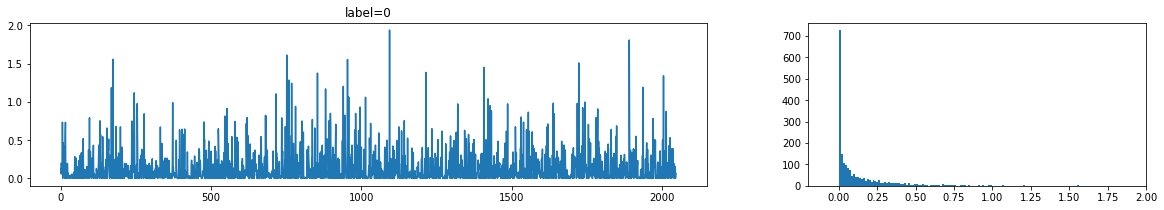

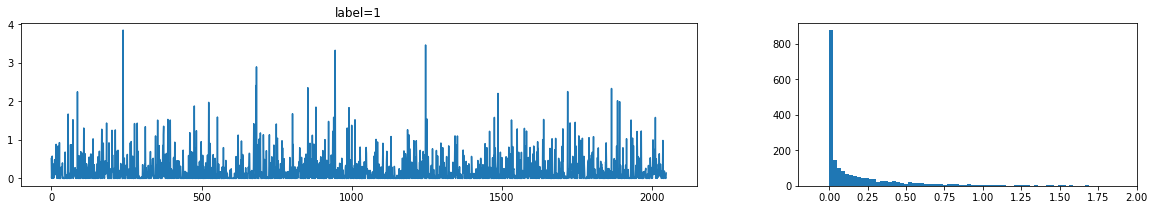

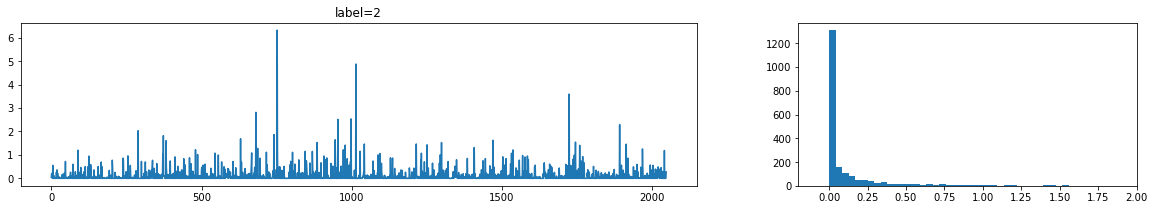

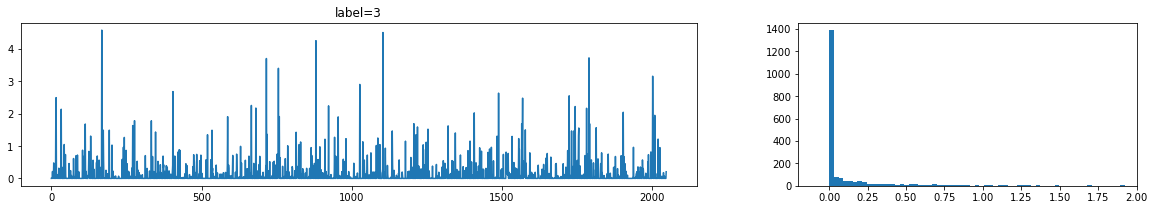

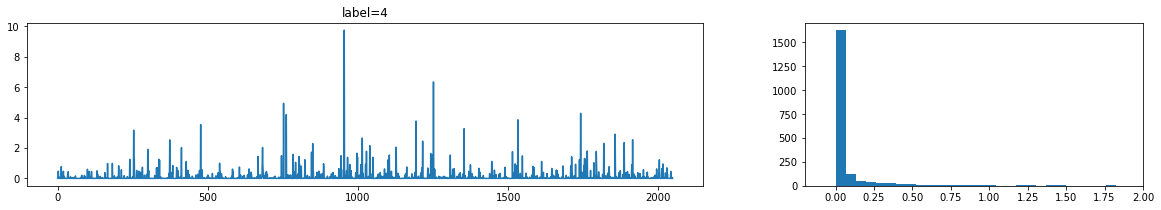

In [13]:
np.random.seed(42)

for label in range(5):
    n = (train_dataset.labels==label).sum()
    rand_ind = np.random.randint(n)
    label_features = train_dataset.features[train_dataset.labels==label]
    datapoint = label_features[rand_ind]
    fig,axs = plt.subplots(ncols=2,figsize=(20,3),gridspec_kw={'width_ratios': [2, 1]})
    axs[0].set_title(f'label={label}')
    axs[0].plot(datapoint)
    axs[1].set_xlim(-0.2,2)
    axs[1].hist(datapoint.numpy(),bins=150)
sample_0 = train_dataset[train_dataset.labels==0][0]

### 2.2

In [15]:
import torch.nn as nn
import torch.optim as optim

class MyModel(nn.Module):
    def __init__(self,input_size,conv_sizes,pool_sizes,drop_p=0.25):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=conv_sizes[0])
        self.pool1 = nn.MaxPool1d(pool_sizes[0])
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=conv_sizes[1])
        self.pool2 = nn.MaxPool1d(pool_sizes[1])
        #self.conv3 = nn.Conv1d(in_channels=1, out_channels=1, kernel_size=conv_sizes[2])
        #self.pool3 = nn.MaxPool1d(pool_sizes[2])
        self.fc_input_size = self.get_fc_input_size(torch.randn(1,input_size))
        self.fc1 = nn.Linear(self.fc_input_size, 5)
        #self.fc2 = nn.Linear(20, 5)
        self.dropout = nn.Dropout(p=drop_p)
        self.sigmoid = nn.Sigmoid()
    
    def get_fc_input_size(self,x):
        output = self.conv1(x)
        output = self.pool1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.pool2(output)
        #output = self.conv3(output)
        #output = self.pool3(output)
        return output.shape[-1]
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.pool1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.pool2(output)
        output = self.relu(output)
        #output = self.conv3(output)
        #output = self.pool3(output)
        #output = self.relu(output)
        
        output = self.fc1(output)
        #output = self.relu(output)
        #output = self.fc2(output)
        output = self.dropout(output)
        #output = self.sigmoid(output)
        return output

In [21]:
model = MyModel(input_size=2048,conv_sizes=[21,15],pool_sizes=[3,2],drop_p=0.2)

lr = 0.003
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(),lr=lr)
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.6)


loaders = {"train": train_loader, "val": val_loader}

activation = nn.Sigmoid()

#-------------------------------------------------------------
l1_lambda = 0.0001
l2_lambda = 0.001

max_epochs = 1500
accuracy = {"train": [], "val": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch, path in dataloader:
            if k == "train":
                model.train()
                model.zero_grad()
                outp = model(x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[1])).reshape(
                    x_batch.shape[0], 5)
            else:
                model.eval()
                outp = model(x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[1])).reshape(
                    x_batch.shape[0], 5)
            preds = torch.argmax(activation(outp), dim=1).flatten()
            correct = (preds == y_batch).sum()
            epoch_correct += correct.item()
            epoch_all += y_batch.shape[0]
            if k == "train":
                loss = criterion(outp, y_batch)
                l1_reg, l2_reg = torch.tensor(0.), torch.tensor(0.)
                for param in model.parameters():
                    l2_reg += torch.norm(param, p=2)
                    l1_reg += torch.norm(param, p=1)
                #loss += l2_lambda * l2_reg 
                loss += l1_lambda * l1_reg
                loss.backward()
                optimizer.step()
                #scheduler.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)
    scheduler.step()

Epoch: 1
Loader: train. Accuracy: 0.4896142433234421
Loader: val. Accuracy: 0.7944664031620553
Epoch: 2
Loader: train. Accuracy: 0.777942631058358
Loader: val. Accuracy: 0.8458498023715415
Epoch: 3
Loader: train. Accuracy: 0.8318496538081108
Loader: val. Accuracy: 0.8893280632411067
Epoch: 4
Loader: train. Accuracy: 0.8447082096933729
Loader: val. Accuracy: 0.8843873517786561
Epoch: 5
Loader: train. Accuracy: 0.8674579624134521
Loader: val. Accuracy: 0.9031620553359684
Epoch: 6
Loader: train. Accuracy: 0.8837784371909001
Loader: val. Accuracy: 0.9130434782608695
Epoch: 7
Loader: train. Accuracy: 0.8827893175074184
Loader: val. Accuracy: 0.8992094861660079
Epoch: 8
Loader: train. Accuracy: 0.8882294757665677
Loader: val. Accuracy: 0.91600790513834
Epoch: 9
Loader: train. Accuracy: 0.8882294757665677
Loader: val. Accuracy: 0.9041501976284585
Epoch: 10
Loader: train. Accuracy: 0.8981206726013847
Loader: val. Accuracy: 0.9150197628458498
Epoch: 11
Loader: train. Accuracy: 0.902077151335311

Epoch: 87
Loader: train. Accuracy: 0.9287833827893175
Loader: val. Accuracy: 0.9189723320158103
Epoch: 88
Loader: train. Accuracy: 0.9381800197823936
Loader: val. Accuracy: 0.9179841897233202
Epoch: 89
Loader: train. Accuracy: 0.9332344213649851
Loader: val. Accuracy: 0.9169960474308301
Epoch: 90
Loader: train. Accuracy: 0.9297725024727992
Loader: val. Accuracy: 0.9100790513833992
Epoch: 91
Loader: train. Accuracy: 0.9357072205736894
Loader: val. Accuracy: 0.9209486166007905
Epoch: 92
Loader: train. Accuracy: 0.9347181008902077
Loader: val. Accuracy: 0.9169960474308301
Epoch: 93
Loader: train. Accuracy: 0.9342235410484668
Loader: val. Accuracy: 0.9189723320158103
Epoch: 94
Loader: train. Accuracy: 0.9332344213649851
Loader: val. Accuracy: 0.9179841897233202
Epoch: 95
Loader: train. Accuracy: 0.9277942631058358
Loader: val. Accuracy: 0.9169960474308301
Epoch: 96
Loader: train. Accuracy: 0.9386745796241345
Loader: val. Accuracy: 0.9150197628458498
Epoch: 97
Loader: train. Accuracy: 0.936

Epoch: 172
Loader: train. Accuracy: 0.9391691394658753
Loader: val. Accuracy: 0.9179841897233202
Epoch: 173
Loader: train. Accuracy: 0.9411473788328387
Loader: val. Accuracy: 0.9189723320158103
Epoch: 174
Loader: train. Accuracy: 0.9362017804154302
Loader: val. Accuracy: 0.9189723320158103
Epoch: 175
Loader: train. Accuracy: 0.9272997032640949
Loader: val. Accuracy: 0.9189723320158103
Epoch: 176
Loader: train. Accuracy: 0.9376854599406528
Loader: val. Accuracy: 0.9189723320158103
Epoch: 177
Loader: train. Accuracy: 0.9312561819980217
Loader: val. Accuracy: 0.9179841897233202
Epoch: 178
Loader: train. Accuracy: 0.93026706231454
Loader: val. Accuracy: 0.9189723320158103
Epoch: 179
Loader: train. Accuracy: 0.9332344213649851
Loader: val. Accuracy: 0.9179841897233202
Epoch: 180
Loader: train. Accuracy: 0.9362017804154302
Loader: val. Accuracy: 0.9189723320158103
Epoch: 181
Loader: train. Accuracy: 0.9317507418397626
Loader: val. Accuracy: 0.9189723320158103
Epoch: 182
Loader: train. Accura

Epoch: 257
Loader: train. Accuracy: 0.9381800197823936
Loader: val. Accuracy: 0.9179841897233202
Epoch: 258
Loader: train. Accuracy: 0.9366963402571711
Loader: val. Accuracy: 0.9169960474308301
Epoch: 259
Loader: train. Accuracy: 0.9287833827893175
Loader: val. Accuracy: 0.9169960474308301
Epoch: 260
Loader: train. Accuracy: 0.9327398615232443
Loader: val. Accuracy: 0.9169960474308301
Epoch: 261
Loader: train. Accuracy: 0.9312561819980217
Loader: val. Accuracy: 0.9169960474308301
Epoch: 262
Loader: train. Accuracy: 0.9342235410484668
Loader: val. Accuracy: 0.9169960474308301
Epoch: 263
Loader: train. Accuracy: 0.9322453016815034
Loader: val. Accuracy: 0.9169960474308301
Epoch: 264
Loader: train. Accuracy: 0.9312561819980217
Loader: val. Accuracy: 0.9169960474308301
Epoch: 265
Loader: train. Accuracy: 0.9426310583580614
Loader: val. Accuracy: 0.9169960474308301
Epoch: 266
Loader: train. Accuracy: 0.9297725024727992
Loader: val. Accuracy: 0.9169960474308301
Epoch: 267
Loader: train. Accu

KeyboardInterrupt: 

In [23]:
print(model.get_fc_input_size(torch.randn(1,2048)))

331


0.924901185770751


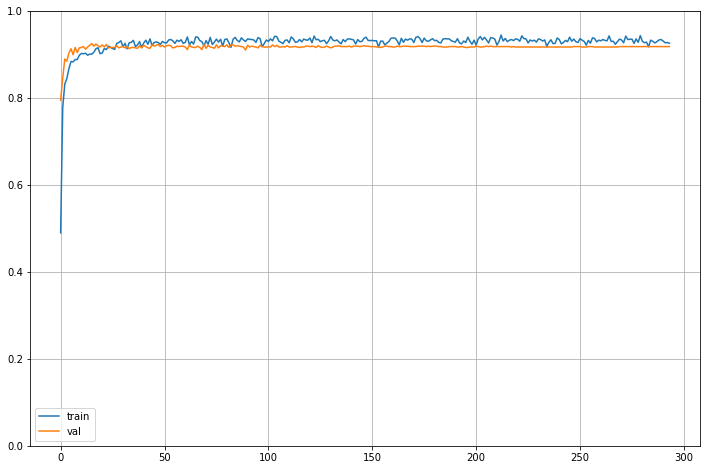

In [24]:
plt.figure(figsize=(12,8))
plt.plot(accuracy['train'],label='train')
plt.plot(accuracy['val'],label='val')
plt.ylim(0, 1)
plt.grid()
plt.legend()
print(max(accuracy['val']))